In [10]:
%reload_ext nb_black

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from pandas_profiling import ProfileReport

import altair as alt

from scipy import stats
from scipy.stats import norm, skew
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn


import os

os.chdir('.../Case Work/Project Lightning/')
datafile = '230428 trucking2303_shared with AAG_color.xlsx'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
freq = "QUARTERLY"
df = pd.read_excel(datafile, sheet_name=freq).T
new_header = df.iloc[1] #grab the first row for the header
df = df[3:] #take the data less the header row
df.columns = new_header #set the header row as the df header
df.drop(['Label: (SA = seasonally adjusted)'], axis=1, inplace=True)
df = df.loc[:, df.columns.notna()]
df.dropna(axis = 0, how = 'all', inplace = True)

cols = df.select_dtypes(exclude=['float']).columns
df[cols] = df[cols].apply(pd.to_numeric, downcast='float', errors='coerce')

if freq == "QUARTERLY":
    df['Date'] = pd.date_range('2000-01-01', '2025-12-01', freq='QS')
    df['Year'] = df['Date'].dt.year
    df['Quarter'] = df['Date'].dt.quarter
    df = df[ ['Date'] + ['Year'] + ['Quarter'] + [ col for col in df.columns if col != 'Date'] ]
else:
    df['Date'] = pd.date_range('2000-01-01', '2025-01-01', freq='MS')
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df = df[ ['Date'] + ['Year'] + ['Month'] + [ col for col in df.columns if col != 'Date'] ]


display(df.describe())



Unnamed: 1,Year,Quarter,Active Truck Utilization (SA),Total Truck Loadings (SA),"Total TL: Spot Rate (exc. FSC, SA)","Total TL: Contract Rate (exc. FSC, SA)","Driver Labor Index (1992=100, SA)","Truck Driver Pressure Index (0 = Neutral, SA)",Real GDP,CPI Index,"3 Month T-Bill Rate, %",National Avg. Diesel Fuel Price ($/Gal.),TCI Component: Loads,TCI Component: Utilization,TCI Component: Diesel,TCI Component: Capital,Year,Quarter
count,104.00000,104.000000,104.000000,1.040000e+02,72.000000,72.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,28.000000,28.000000,28.000000,28.000000,104.00000,104.000000
mean,2012.50000,2.500000,0.909791,1.739228e+08,112.676071,120.851532,120.870682,0.087948,16797.249586,2.342130,1.919127,2.975320,0.832728,-0.088572,-0.197416,-0.894322,2012.50000,2.500000
std,7.53632,1.123448,0.044867,1.577288e+07,17.677216,18.209970,7.377230,5.701280,2332.830338,0.431301,1.970776,0.997807,1.014326,1.730548,1.969284,1.003365,7.53632,1.123448
min,2000.00000,1.000000,0.818753,1.421712e+08,77.902023,95.654587,105.248306,-11.974460,12935.252000,1.701000,0.013333,1.178333,-2.010636,-2.507626,-7.396975,-3.390149,2000.00000,1.000000
25%,2006.00000,1.750000,0.878123,1.626295e+08,103.122383,105.698410,113.009853,-3.726186,15209.354000,2.020667,0.123333,2.368833,0.224864,-1.394651,-0.444129,-1.277944,2006.00000,1.750000
50%,2012.50000,2.500000,0.902286,1.715567e+08,108.940704,114.899826,124.596096,-1.007951,16370.760000,2.317072,1.201667,2.919000,0.807624,-0.359736,0.115642,-0.699669,2012.50000,2.500000
75%,2019.00000,3.250000,0.936137,1.909591e+08,119.990997,139.079742,125.628685,4.476465,18766.643066,2.555185,3.501532,3.889917,1.451560,0.616379,0.594839,-0.156019,2019.00000,3.250000
max,2025.00000,4.000000,1.000000,1.992374e+08,162.431305,156.782104,130.137955,11.560026,21040.896484,3.358075,6.200000,5.481667,3.487860,4.558047,2.970726,0.323188,2025.00000,4.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [83]:
train_missing = (df.isnull().sum()/len(df)) *100
train_missing = train_missing.drop(train_missing[train_missing ==0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Percentage': train_missing})
missing_data

,Missing Percentage
Unnamed: 1,
TCI Component: Loads,73.076923
TCI Component: Utilization,73.076923
TCI Component: Diesel,73.076923
TCI Component: Capital,73.076923
"Total TL: Spot Rate (exc. FSC, SA)",30.769231
"Total TL: Contract Rate (exc. FSC, SA)",30.769231


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# timeseries_heatmap(dataframe=df, entity_column='Site Num', sortby='Date')

profile = ProfileReport(df, tsmode=True, sortby="Date")
profile.to_file(freq+'_profile_report.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 49.55it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
train_spot = df[['Date', 'Total TL: Spot Rate (exc. FSC, SA)']].dropna()
train_spot.set_index('Date', inplace=True)
train_spot.index.freq='QS'
train_spot.index

train_contract = df[['Date', 'Total TL: Contract Rate (exc. FSC, SA)']].dropna()
train_contract.set_index('Date', inplace=True)
train_contract.index.freq='QS'
train_contract.index


DatetimeIndex(['2008-01-01', '2008-04-01', '2008-07-01', '2008-10-01',
               '2009-01-01', '2009-04-01', '2009-07-01', '2009-10-01',
               '2010-01-01', '2010-04-01', '2010-07-01', '2010-10-01',
               '2011-01-01', '2011-04-01', '2011-07-01', '2011-10-01',
               '2012-01-01', '2012-04-01', '2012-07-01', '2012-10-01',
               '2013-01-01', '2013-04-01', '2013-07-01', '2013-10-01',
               '2014-01-01', '2014-04-01', '2014-07-01', '2014-10-01',
               '2015-01-01', '2015-04-01', '2015-07-01', '2015-10-01',
               '2016-01-01', '2016-04-01', '2016-07-01', '2016-10-01',
               '2017-01-01', '2017-04-01', '2017-07-01', '2017-10-01',
               '2018-01-01', '2018-04-01', '2018-07-01', '2018-10-01',
               '2019-01-01', '2019-04-01', '2019-07-01', '2019-10-01',
               '2020-01-01', '2020-04-01', '2020-07-01', '2020-10-01',
               '2021-01-01', '2021-04-01', '2021-07-01', '2021-10-01',
      

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Contract rate


<AxesSubplot: xlabel='Unnamed: 1-Date', ylabel='Date'>

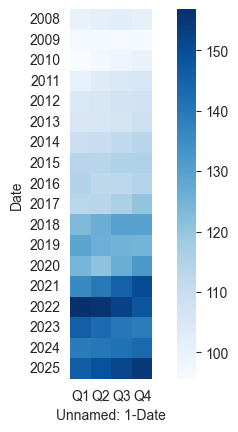

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [85]:
print('Contract rate')
sns.heatmap(pd.pivot_table(data=train_contract, index=train_contract.index.year, columns=train_contract.index.quarter),
           square=True,
           cmap='Blues',
           xticklabels=["Q1", "Q2", "Q3", "Q4"])



Spot rate


<AxesSubplot: xlabel='Unnamed: 1-Date', ylabel='Date'>

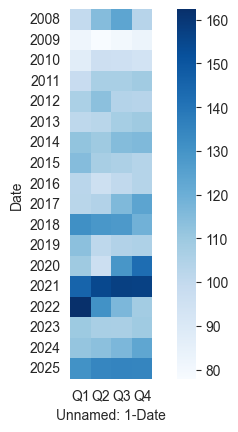

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [69]:
print('Spot rate')
sns.heatmap(pd.pivot_table(data=train_spot, index=train_spot.index.year, columns=train_spot.index.quarter),
           square=True,
           cmap='Blues',
           xticklabels=["Q1", "Q2", "Q3", "Q4"])

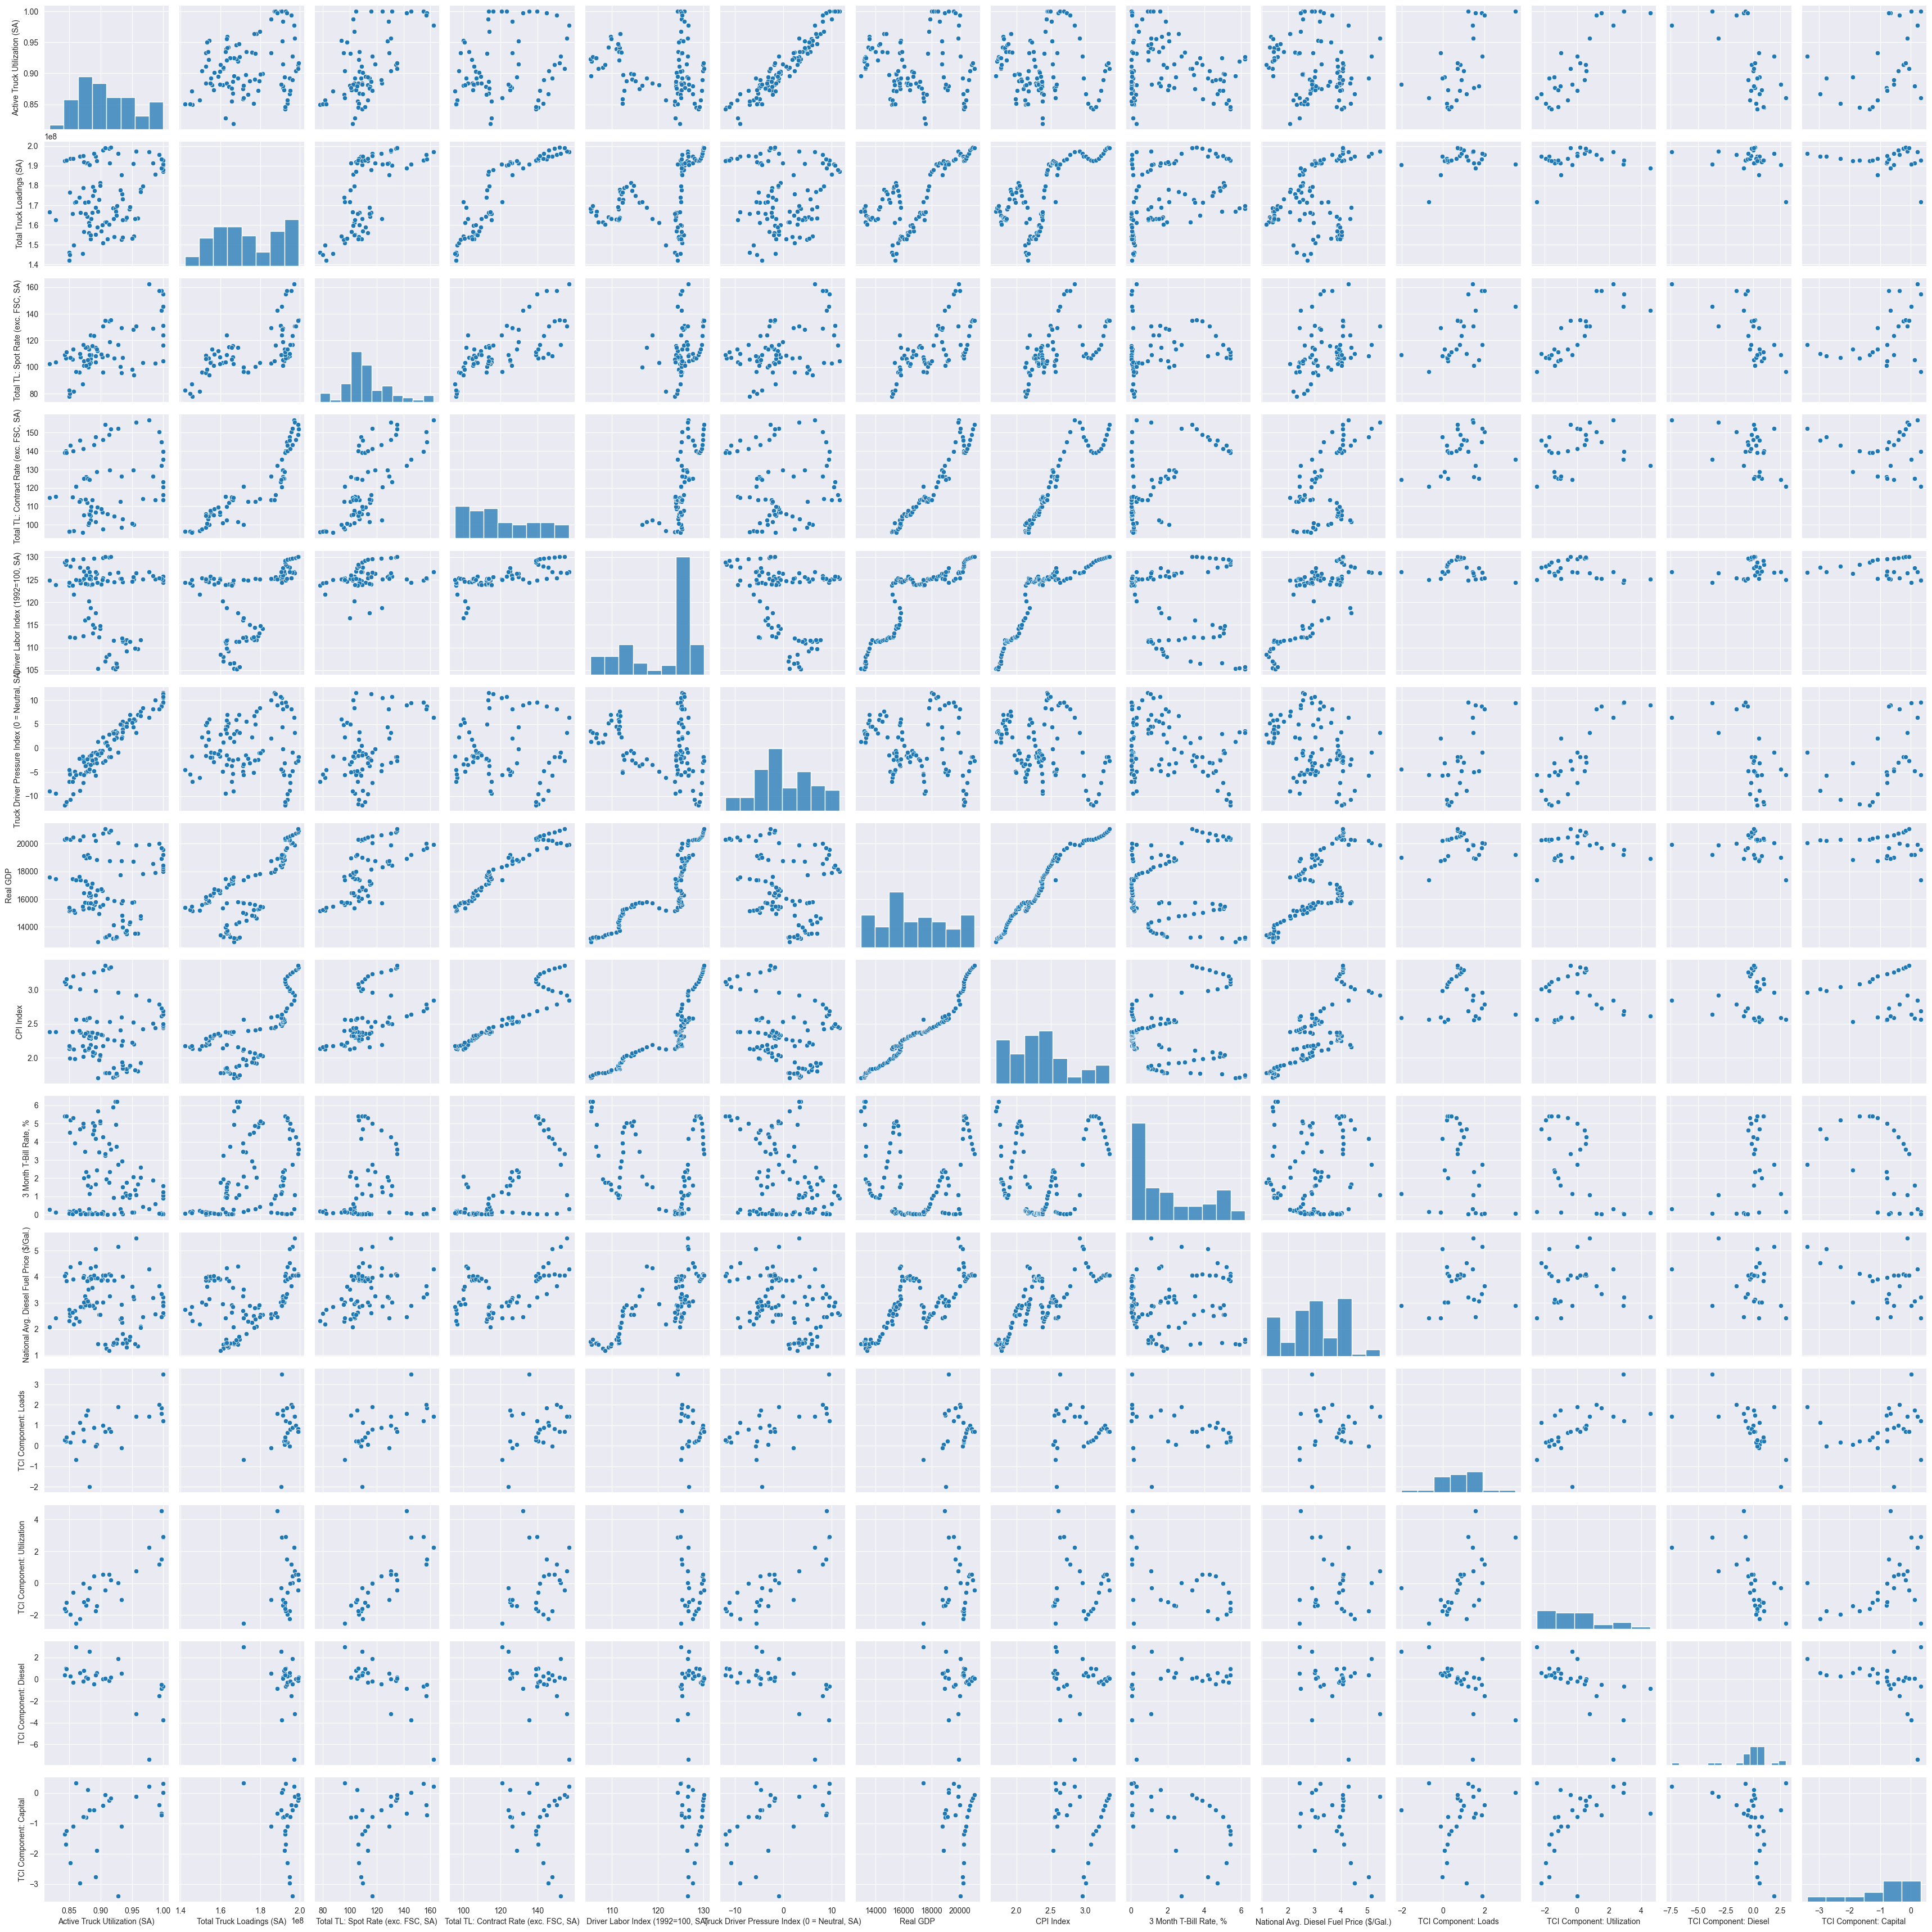

<IPython.core.display.Javascript object>

In [5]:
sns.pairplot(df)

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

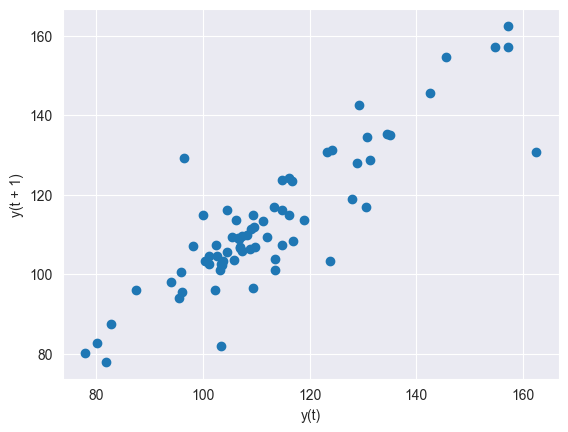

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
pd.plotting.lag_plot(train_spot["Total TL: Spot Rate (exc. FSC, SA)"],1)

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 4)'>

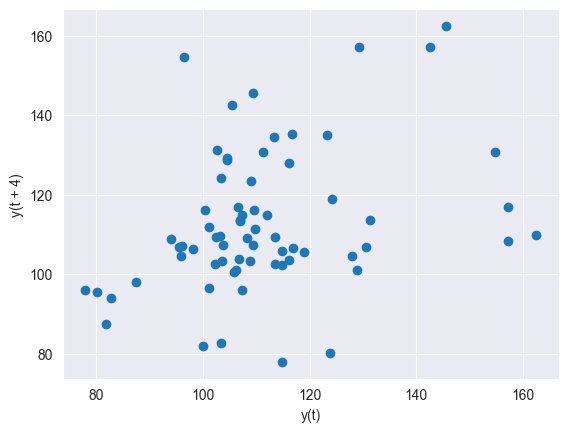

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [76]:
pd.plotting.lag_plot(train_spot["Total TL: Spot Rate (exc. FSC, SA)"],4)